# Crypto Trading Strategy Monte Carlo Analysis

This notebook performs comprehensive Monte Carlo simulations on crypto trading strategies.

## Key Metrics Calculated:
- **Monte Carlo Simulation**: Multiple backtest runs to assess strategy robustness
- **Sharpe Ratio**: Risk-adjusted return metric (higher is better, >1.0 is good)
- **Expected Value**: Expected profit/loss per trade (positive = profitable strategy)
- **Sortino Ratio**: Downside risk-adjusted return
- **Pass Rate**: Percentage of simulations that pass funded account rules


In [68]:
# Import Daily Bias 4H Strategy Framework
import sys
import os

# Add current directory to path to import the strategy module
if os.path.dirname(os.path.abspath('daily_bias_4h_strategy.py')) not in sys.path:
    sys.path.insert(0, os.path.dirname(os.path.abspath('daily_bias_4h_strategy.py')))

try:
    from daily_bias_4h_strategy import strategy as daily_bias_strategy
    print("✅ Daily Bias 4H Strategy imported successfully!")
    print("   Strategy includes:")
    print("   - 4H Session-based bias detection")
    print("   - CISD (Change in Structure Direction) on 5m timeframe")
    print("   - Multi-timeframe confirmation (4H bias + 5m CISD)")
    print("   - Session reversal patterns (Asia, London, NY 6am/10am)")
except ImportError as e:
    print(f"⚠️ Warning: Could not import daily_bias_4h_strategy: {e}")
    daily_bias_strategy = None


✅ Daily Bias 4H Strategy imported successfully!
   Strategy includes:
   - 4H Session-based bias detection
   - CISD (Change in Structure Direction) on 5m timeframe
   - Multi-timeframe confirmation (4H bias + 5m CISD)
   - Session reversal patterns (Asia, London, NY 6am/10am)


In [69]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime, timedelta
import pytz
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Load crypto data from .Last.txt files (semicolon-separated format)
# Format: Date Time;Open;High;Low;Close;Volume

data_folders = ["BTCUSD DATA", "ETHUSD DATA", "SOLUSD DATA"]
dfs = []

for folder in data_folders:
    if not os.path.exists(folder):
        print(f"Warning: Folder '{folder}' not found, skipping...")
        continue
    
    # Find all .Last.txt files in the folder
    txt_files = glob.glob(os.path.join(folder, "*.Last.txt"))
    
    for f in txt_files:
        try:
            # Read semicolon-separated file with no header
            df = pd.read_csv(f, sep=';', header=None, 
                           names=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume'])
            
            # Parse datetime from format: YYYYMMDD HHMMSS
            df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d %H%M%S')
            
            # Set datetime as index and sort
            df = df.set_index('DateTime').sort_index()
            
            # Add ticker name from folder
            ticker = folder.replace(' DATA', '').replace('USD', '')
            df['Ticker'] = ticker
            
            dfs.append(df)
            print(f"Loaded {len(df)} rows from {os.path.basename(f)}")
            
        except Exception as e:
            print(f"Error loading {f}: {e}")

# Concatenate all DataFrames if any were loaded
if len(dfs) > 0:
    price = pd.concat(dfs, ignore_index=False)
    print(f"\nTotal rows loaded: {len(price)}")
    print(f"Date range: {price.index.min()} to {price.index.max()}")
    print(f"\nFirst few rows:")
    print(price.head())
else:
    print("No data files found! Please check the data folders.")
    price = pd.DataFrame()  # Create empty DataFrame to avoid errors



Libraries imported successfully!
Loaded 525600 rows from BTCUSDT_2019_minute.Last.txt
Loaded 527040 rows from BTCUSDT_2020_minute.Last.txt
Loaded 525600 rows from BTCUSDT_2021_minute.Last.txt
Loaded 525600 rows from BTCUSDT_2022_minute.Last.txt
Loaded 525600 rows from BTCUSDT_2023_minute.Last.txt
Loaded 527040 rows from BTCUSDT_2024_minute.Last.txt
Loaded 499680 rows from BTCUSDT_2025_minute.Last.txt
Loaded 525600 rows from ETHUSDT_2019_minute.Last.txt
Loaded 527040 rows from ETHUSDT_2020_minute.Last.txt
Loaded 525600 rows from ETHUSDT_2021_minute.Last.txt
Loaded 525600 rows from ETHUSDT_2022_minute.Last.txt
Loaded 525600 rows from ETHUSDT_2023_minute.Last.txt
Loaded 527040 rows from ETHUSDT_2024_minute.Last.txt
Loaded 499680 rows from ETHUSDT_2025_minute.Last.txt
Loaded 525600 rows from SOLUSDT_2023_minute.Last.txt
Loaded 527040 rows from SOLUSDT_2024_minute.Last.txt
Loaded 499680 rows from SOLUSDT_2025_minute.Last.txt

Total rows loaded: 8864640
Date range: 2019-01-01 00:00:00 to 202

## 2. Backtesting Engine

This class handles backtesting with account rules and risk metrics.


In [70]:
class CryptoBacktester:
    """
    Backtesting engine for crypto trading strategies with funded account rules.
    """
    
    def __init__(self, account_size=5000, daily_dd_limit=0.02, max_dd_limit=0.03,
                 entry_size=4800, target_gain=500):
        self.account_size = account_size
        self.daily_dd_limit = daily_dd_limit
        self.max_dd_limit = max_dd_limit
        self.entry_size = entry_size
        self.target_gain = target_gain
        
    def run_backtest(self, trades_df, strategy_func=None):
        """
        Run backtest on trades DataFrame.
        
        Parameters:
        -----------
        trades_df : pd.DataFrame
            DataFrame with columns: entry_price, exit_price, entry_time, symbol
        strategy_func : function, optional
            Custom strategy function that returns ('BUY', confidence) or ('HOLD', confidence)
            
        Returns:
        --------
        dict : Backtest results with metrics
        """
        equity_curve = [self.account_size]
        trade_log = []
        current_equity = self.account_size
        peak_equity = self.account_size
        daily_peak = self.account_size
        current_date = None
        
        for _, trade in trades_df.iterrows():
            # Apply strategy if provided, otherwise use trade's existing signal
            if strategy_func:
                try:
                    signal, confidence = strategy_func(trade, {'equity': current_equity})
                    if signal != 'BUY':
                        continue
                except:
                    continue
            else:
                # No strategy function - check if trade has signal column
                # If trades already have signals (like CISD trades), use them
                if 'signal' in trade:
                    if trade['signal'] not in ['BUY', 'SELL']:
                        continue
                # If no signal column, assume all trades are valid
            
            entry_price = trade['entry_price']
            exit_price = trade['exit_price']
            side = trade.get('side', 'LONG')  # Default to LONG if not specified
            
            # Calculate PnL (handle both LONG and SHORT)
            if side == 'SHORT':
                # For shorts, profit when price goes down
                pnl = self.entry_size * ((entry_price - exit_price) / entry_price)
            else:
                # For longs, profit when price goes up
                pnl = self.entry_size * ((exit_price - entry_price) / entry_price)
            
            new_equity = current_equity + pnl
            
            # Check daily DD
            if daily_peak > 0:
                daily_dd = (daily_peak - new_equity) / daily_peak
                if daily_dd > self.daily_dd_limit:
                    break
            
            # Check max DD
            if peak_equity > 0:
                max_dd = (peak_equity - new_equity) / peak_equity
                if max_dd > self.max_dd_limit:
                    break
            
            current_equity = new_equity
            if current_equity > peak_equity:
                peak_equity = current_equity
            if current_equity > daily_peak:
                daily_peak = current_equity
            
            trade_log.append({
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl,
                'equity': current_equity
            })
            
            equity_curve.append(current_equity)
            
            # Check target gain
            if current_equity - self.account_size >= self.target_gain:
                break
        
        # Calculate metrics
        equity_array = np.array(equity_curve)
        total_pnl = current_equity - self.account_size
        return_pct = (total_pnl / self.account_size) * 100
        
        # Drawdown calculation
        rolling_max = np.maximum.accumulate(equity_array)
        drawdowns = (rolling_max - equity_array) / rolling_max
        max_dd = drawdowns.max() * 100 if len(drawdowns) > 0 else 0
        
        # Returns for Sharpe/Sortino
        returns = np.diff(equity_array) / equity_array[:-1]
        returns = returns[~np.isnan(returns)]
        
        # Sharpe Ratio (annualized, assuming 312 trading days)
        if len(returns) > 1 and returns.std() > 0:
            sharpe = (returns.mean() * np.sqrt(312)) / returns.std()
        else:
            sharpe = 0
        
        # Sortino Ratio (only downside volatility)
        downside_returns = returns[returns < 0]
        if len(downside_returns) > 1 and downside_returns.std() > 0:
            sortino = (returns.mean() * np.sqrt(312)) / downside_returns.std()
        else:
            sortino = 0
        
        # Expected Value (average PnL per trade)
        if len(trade_log) > 0:
            expected_value = np.mean([t['pnl'] for t in trade_log])
        else:
            expected_value = 0
        
        return {
            'final_equity': current_equity,
            'total_pnl': total_pnl,
            'return_pct': return_pct,
            'num_trades': len(trade_log),
            'max_dd_pct': max_dd,
            'sharpe': sharpe,
            'sortino': sortino,
            'expected_value': expected_value,
            'equity_curve': equity_curve,
            'trade_log': trade_log,
            'passed': total_pnl >= self.target_gain and max_dd < self.max_dd_limit * 100
        }

print("Backtesting engine defined!")


Backtesting engine defined!


## 3. Prepare Trade Data

Convert price data into trade format for backtesting.


In [71]:
# Override: Use ALL available data points (if not already done)
if len(trades_df) > 0 and len(trades_df) < 10000:
    # Re-prepare with all data if we have less than 10k trades
    if 'price' in locals() and len(price) > 0 and 'Ticker' in price.columns:
        btc_data = price[price['Ticker'] == 'BTC'].copy()
        trades_df = prepare_trades_from_data(btc_data, symbol='BTC', sample_interval=1, max_trades=999999)
        print(f"✅ Updated: Using ALL {len(trades_df):,} available trades from CSV data")
        print(f"   Date range: {trades_df['entry_time'].min()} to {trades_df['entry_time'].max()}")


✅ Updated: Using ALL 533,189 available trades from CSV data
   Date range: 2019-01-01 13:30:00 to 2025-12-13 16:58:00


In [72]:
# Prepare trade data from price data
# Filter to trading window (7:30-11:00 AM Chicago time)
CHICAGO_TZ = pytz.timezone('America/Chicago')

def prepare_trades_from_data(price_df, symbol='BTC', sample_interval=5, max_trades=1000):
    """
    Convert price data to trade format.
    """
    # Filter to trading hours
    price_df['chicago_time'] = price_df.index.tz_localize('UTC').tz_convert(CHICAGO_TZ)
    price_df['hour'] = price_df['chicago_time'].dt.hour
    price_df['minute'] = price_df['chicago_time'].dt.minute
    
    # Filter to 7:30-11:00 AM Chicago time
    mask = ((price_df['hour'] == 7) & (price_df['minute'] >= 30)) | \
           ((price_df['hour'] >= 8) & (price_df['hour'] < 11))
    
    window_data = price_df[mask].copy()
    
    if len(window_data) == 0:
        return pd.DataFrame()
    
    # Sample every Nth bar
    window_data = window_data.iloc[::sample_interval].head(max_trades)
    
    # Create trades DataFrame
    trades = []
    for i in range(1, len(window_data)):
        current = window_data.iloc[i]
        previous = window_data.iloc[i-1]
        
        trades.append({
            'symbol': symbol,
            'entry_price': previous['Close'],
            'exit_price': current['Close'],
            'entry_time': previous.name,
            'high': current['High'],
            'low': current['Low'],
            'volume': current['Volume'],
            'price_range': current['High'] - current['Low'],
            'cvd': 0,  # Simplified
            'cvd_ma': 0,
            'recent_high': window_data['High'].iloc[max(0, i-20):i].max(),
            'recent_low': window_data['Low'].iloc[max(0, i-20):i].min(),
        })
    
    return pd.DataFrame(trades)

# Prepare trades for BTC
if len(price) > 0 and 'Ticker' in price.columns:
    btc_data = price[price['Ticker'] == 'BTC'].copy()
    trades_df = prepare_trades_from_data(btc_data, symbol='BTC', sample_interval=5, max_trades=500)
    print(f"Prepared {len(trades_df)} trades from BTC data")
    print(f"Date range: {trades_df['entry_time'].min()} to {trades_df['entry_time'].max()}")
else:
    print("No price data available. Please load data first.")
    trades_df = pd.DataFrame()


Prepared 499 trades from BTC data
Date range: 2019-01-01 13:30:00 to 2019-01-12 16:30:00


## 3.5 CISD Multi-Timeframe Strategy Implementation

This section implements the CISD (Cumulative Imbalance Supply/Demand) strategy with multi-timeframe analysis:
- **4H Chart**: Session-profile model to define bias (6am-10am NYC session)
- **5m Chart**: CISD signals within the active 4H candle
- **Entry Rules**: CISD signals aligned with 4H bias


In [73]:
# ============================================================================
# CISD MULTI-TIMEFRAME STRATEGY IMPLEMENTATION
# ============================================================================

NYC_TZ = pytz.timezone('America/New_York')
CHICAGO_TZ = pytz.timezone('America/Chicago')

class CISDStrategy:
    """
    CISD Multi-Timeframe Strategy
    
    - 4H Chart: Session-profile model for bias (6am-10am NYC session)
    - 5m Chart: CISD signals within active 4H candle
    - Entry: CISD signals aligned with 4H bias
    """
    
    def __init__(self, entry_window_start=6, entry_window_end=10, 
                 htf_timeframe='4H', ltf_timeframe='5m'):
        """
        Parameters:
        -----------
        entry_window_start : int
            Start hour for entry window (NYC time, 24h format)
        entry_window_end : int
            End hour for entry window (NYC time, 24h format)
        htf_timeframe : str
            Higher timeframe (e.g., '4H')
        ltf_timeframe : str
            Lower timeframe (e.g., '5m')
        """
        self.entry_window_start = entry_window_start
        self.entry_window_end = entry_window_end
        self.htf_timeframe = htf_timeframe
        self.ltf_timeframe = ltf_timeframe
        
        # State tracking
        self.current_4h_candle = None
        self.htf_bias = None  # 'bullish', 'bearish', or None
        self.bullish_cisd_signal = False
        self.bearish_cisd_signal = False
        self.recent_bearish_leg_open = None
        self.recent_bullish_leg_open = None
        
    def detect_cisd(self, current_bar, previous_bars, lookback=20):
        """
        Detect CISD (Cumulative Imbalance Supply/Demand) signals.
        
        CISD Logic:
        - Bullish CISD: Price closes above the open of the most recent bearish leg
        - Bearish CISD: Price closes below the open of the most recent bullish leg
        
        Parameters:
        -----------
        current_bar : pd.Series
            Current bar with Open, High, Low, Close
        previous_bars : pd.DataFrame
            Previous bars for lookback analysis
        lookback : int
            Number of bars to look back for leg detection
            
        Returns:
        --------
        tuple: (bullish_cisd, bearish_cisd)
        """
        if len(previous_bars) < 2:
            return False, False
        
        bullish_cisd = False
        bearish_cisd = False
        
        # Find most recent bearish leg (series of lower closes)
        bearish_leg_found = False
        bearish_leg_open = None
        
        for i in range(len(previous_bars) - 1, max(0, len(previous_bars) - lookback) - 1, -1):
            if i < 1:
                break
            bar = previous_bars.iloc[i]
            prev_bar = previous_bars.iloc[i-1]
            
            # Check if this is part of a bearish leg (lower closes)
            if bar['Close'] < prev_bar['Close']:
                if not bearish_leg_found:
                    bearish_leg_open = bar['Open']
                    bearish_leg_found = True
            else:
                if bearish_leg_found:
                    break
        
        # Find most recent bullish leg (series of higher closes)
        bullish_leg_found = False
        bullish_leg_open = None
        
        for i in range(len(previous_bars) - 1, max(0, len(previous_bars) - lookback) - 1, -1):
            if i < 1:
                break
            bar = previous_bars.iloc[i]
            prev_bar = previous_bars.iloc[i-1]
            
            # Check if this is part of a bullish leg (higher closes)
            if bar['Close'] > prev_bar['Close']:
                if not bullish_leg_found:
                    bullish_leg_open = bar['Open']
                    bullish_leg_found = True
            else:
                if bullish_leg_found:
                    break
        
        # Check for Bullish CISD: Price closes above the open of most recent bearish leg
        if bearish_leg_open is not None:
            if current_bar['Close'] > bearish_leg_open:
                bullish_cisd = True
                self.recent_bearish_leg_open = bearish_leg_open
        
        # Check for Bearish CISD: Price closes below the open of most recent bullish leg
        if bullish_leg_open is not None:
            if current_bar['Close'] < bullish_leg_open:
                bearish_cisd = True
                self.recent_bullish_leg_open = bullish_leg_open
        
        return bullish_cisd, bearish_cisd
    
    def determine_4h_bias(self, htf_data, current_time):
        """
        Determine 4H bias using session-profile model.
        
        Focus on 6am-10am NYC session 4H candle.
        Bias is determined by the direction and strength of that candle.
        
        Parameters:
        -----------
        htf_data : pd.DataFrame
            4H timeframe data
        current_time : pd.Timestamp
            Current time to identify active 4H candle
            
        Returns:
        --------
        str: 'bullish', 'bearish', or None
        """
        if len(htf_data) == 0:
            return None
        
        # Convert to NYC time
        if current_time.tzinfo is None:
            current_time = current_time.tz_localize('UTC')
        nyc_time = current_time.tz_convert(NYC_TZ)
        
        # Find 4H candles that overlap with 6am-10am NYC session
        # 4H candles: 0:00, 4:00, 8:00, 12:00, 16:00, 20:00 NYC time
        # We want the candle that contains 6am-10am: that's the 4:00-8:00 or 8:00-12:00 candle
        
        target_hour = nyc_time.hour
        if target_hour >= 6 and target_hour < 10:
            # We're in the 6am-10am window
            # Find the 4H candle that started at 4am or 8am
            candle_start_hour = 4 if target_hour < 8 else 8
        else:
            # Find the most recent 4H candle
            candle_start_hour = (target_hour // 4) * 4
        
        # Find matching 4H candle
        htf_data_nyc = htf_data.copy()
        if htf_data_nyc.index.tzinfo is None:
            htf_data_nyc.index = htf_data_nyc.index.tz_localize('UTC')
        htf_data_nyc.index = htf_data_nyc.index.tz_convert(NYC_TZ)
        
        # Filter to target hour
        matching_candles = htf_data_nyc[htf_data_nyc.index.hour == candle_start_hour]
        
        if len(matching_candles) == 0:
            return None
        
        # Get the most recent matching candle
        recent_candle = matching_candles.iloc[-1]
        
        # Determine bias based on candle direction and strength
        candle_range = recent_candle['High'] - recent_candle['Low']
        candle_body = abs(recent_candle['Close'] - recent_candle['Open'])
        body_ratio = candle_body / candle_range if candle_range > 0 else 0
        
        # Bullish if close > open and strong body
        if recent_candle['Close'] > recent_candle['Open'] and body_ratio > 0.5:
            return 'bullish'
        # Bearish if close < open and strong body
        elif recent_candle['Close'] < recent_candle['Open'] and body_ratio > 0.5:
            return 'bearish'
        # Weak bias if body is small
        else:
            # Use overall trend
            if recent_candle['Close'] > recent_candle['Open']:
                return 'bullish'
            else:
                return 'bearish'
    
    def is_in_entry_window(self, current_time):
        """
        Check if current time is within the entry window.
        
        Parameters:
        -----------
        current_time : pd.Timestamp
            Current timestamp
            
        Returns:
        --------
        bool: True if in entry window
        """
        if current_time.tzinfo is None:
            current_time = current_time.tz_localize('UTC')
        nyc_time = current_time.tz_convert(NYC_TZ)
        hour = nyc_time.hour
        
        return self.entry_window_start <= hour < self.entry_window_end
    
    def check_entry_signal(self, current_bar, previous_bars, current_time, htf_data):
        """
        Check for entry signal based on CISD and 4H bias.
        
        Entry Rules:
        - Bullish: 4H bias bullish AND Bullish CISD formed within entry window
        - Bearish: 4H bias bearish AND Bearish CISD formed within entry window
        
        Parameters:
        -----------
        current_bar : pd.Series
            Current 5m bar
        previous_bars : pd.DataFrame
            Previous 5m bars
        current_time : pd.Timestamp
            Current time
        htf_data : pd.DataFrame
            4H timeframe data
            
        Returns:
        --------
        tuple: (signal, confidence)
            signal: 'BUY', 'SELL', or 'HOLD'
            confidence: float between 0 and 1
        """
        # Check if in entry window
        if not self.is_in_entry_window(current_time):
            return 'HOLD', 0.5
        
        # Determine 4H bias
        htf_bias = self.determine_4h_bias(htf_data, current_time)
        
        if htf_bias is None:
            return 'HOLD', 0.5
        
        # Detect CISD signals
        bullish_cisd, bearish_cisd = self.detect_cisd(current_bar, previous_bars)
        
        # Entry logic
        if htf_bias == 'bullish' and bullish_cisd:
            # Bullish 4H bias + Bullish CISD = Long entry
            return 'BUY', 0.85
        elif htf_bias == 'bearish' and bearish_cisd:
            # Bearish 4H bias + Bearish CISD = Short entry
            return 'SELL', 0.85
        else:
            # No alignment or no CISD signal
            return 'HOLD', 0.5

# Initialize CISD strategy
cisd_strategy = CISDStrategy(
    entry_window_start=6,  # 6am NYC
    entry_window_end=10,   # 10am NYC
    htf_timeframe='4H',
    ltf_timeframe='5m'
)

print("✅ CISD Multi-Timeframe Strategy initialized!")
print(f"   Entry Window: {cisd_strategy.entry_window_start}:00 - {cisd_strategy.entry_window_end}:00 NYC time")
print(f"   Higher Timeframe: {cisd_strategy.htf_timeframe}")
print(f"   Lower Timeframe: {cisd_strategy.ltf_timeframe}")


✅ CISD Multi-Timeframe Strategy initialized!
   Entry Window: 6:00 - 10:00 NYC time
   Higher Timeframe: 4H
   Lower Timeframe: 5m


In [74]:
# ============================================================================
# PREPARE MULTI-TIMEFRAME DATA FOR CISD STRATEGY
# ============================================================================

def prepare_multitimeframe_data(price_df, symbol='BTC'):
    """
    Prepare 4H and 5m timeframe data for CISD strategy.
    
    Parameters:
    -----------
    price_df : pd.DataFrame
        Minute-by-minute price data
    symbol : str
        Trading symbol
        
    Returns:
    --------
    tuple: (htf_data_4h, ltf_data_5m)
    """
    if len(price_df) == 0:
        return pd.DataFrame(), pd.DataFrame()
    
    # Filter to symbol if Ticker column exists
    if 'Ticker' in price_df.columns:
        symbol_data = price_df[price_df['Ticker'] == symbol].copy()
    else:
        symbol_data = price_df.copy()
    
    if len(symbol_data) == 0:
        return pd.DataFrame(), pd.DataFrame()
    
    # Ensure timezone-aware index
    if symbol_data.index.tzinfo is None:
        symbol_data.index = symbol_data.index.tz_localize('UTC')
    
    # Resample to 4H timeframe (higher timeframe)
    htf_4h = symbol_data.resample('4H', label='right', closed='right').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    # Resample to 5m timeframe (lower timeframe)
    ltf_5m = symbol_data.resample('5min', label='right', closed='right').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    # Filter 5m data to entry window (6am-10am NYC)
    ltf_5m_nyc = ltf_5m.copy()
    ltf_5m_nyc.index = ltf_5m_nyc.index.tz_convert(NYC_TZ)
    ltf_5m_nyc['hour'] = ltf_5m_nyc.index.hour
    ltf_5m_nyc = ltf_5m_nyc[(ltf_5m_nyc['hour'] >= 6) & (ltf_5m_nyc['hour'] < 10)]
    ltf_5m_nyc = ltf_5m_nyc.drop('hour', axis=1)
    ltf_5m_nyc.index = ltf_5m_nyc.index.tz_convert('UTC')
    
    return htf_4h, ltf_5m_nyc

# Prepare multi-timeframe data
if len(price) > 0:
    htf_4h_data, ltf_5m_data = prepare_multitimeframe_data(price, symbol='BTC')
    print(f"✅ Prepared multi-timeframe data:")
    print(f"   4H data: {len(htf_4h_data)} candles")
    print(f"   5m data (6am-10am NYC): {len(ltf_5m_data)} candles")
    print(f"   4H date range: {htf_4h_data.index.min()} to {htf_4h_data.index.max()}")
    print(f"   5m date range: {ltf_5m_data.index.min()} to {ltf_5m_data.index.max()}")
else:
    htf_4h_data = pd.DataFrame()
    ltf_5m_data = pd.DataFrame()
    print("⚠️ No price data available for multi-timeframe preparation")


✅ Prepared multi-timeframe data:
   4H data: 15235 candles
   5m data (6am-10am NYC): 121872 candles
   4H date range: 2019-01-01 00:00:00+00:00 to 2025-12-14 00:00:00+00:00
   5m date range: 2019-01-01 11:00:00+00:00 to 2025-12-13 14:55:00+00:00


In [75]:
# ============================================================================
# CONVERT 5M DATA TO TRADES USING CISD STRATEGY
# ============================================================================

def prepare_cisd_trades(ltf_5m_data, htf_4h_data, symbol='BTC', max_trades=1000):
    """
    Convert 5m data to trades using CISD strategy signals.
    
    Parameters:
    -----------
    ltf_5m_data : pd.DataFrame
        5-minute timeframe data (filtered to entry window)
    htf_4h_data : pd.DataFrame
        4-hour timeframe data for bias determination
    symbol : str
        Trading symbol
    max_trades : int
        Maximum number of trades to generate
        
    Returns:
    --------
    pd.DataFrame : Trades DataFrame
    """
    if len(ltf_5m_data) == 0 or len(htf_4h_data) == 0:
        return pd.DataFrame()
    
    trades = []
    lookback_window = 20  # Bars to look back for CISD detection
    
    for i in range(lookback_window + 1, len(ltf_5m_data)):
        if len(trades) >= max_trades:
            break
        
        current_bar = ltf_5m_data.iloc[i]
        previous_bars = ltf_5m_data.iloc[max(0, i-lookback_window):i]
        current_time = ltf_5m_data.index[i]
        
        # Check for entry signal using CISD strategy
        signal, confidence = cisd_strategy.check_entry_signal(
            current_bar, previous_bars, current_time, htf_4h_data
        )
        
        # Only create trade if signal is BUY or SELL
        if signal in ['BUY', 'SELL']:
            # For exit, use next bar's close (or a few bars ahead)
            exit_idx = min(i + 5, len(ltf_5m_data) - 1)  # Exit 5 bars later (25 minutes)
            exit_bar = ltf_5m_data.iloc[exit_idx]
            
            entry_price = current_bar['Close']
            exit_price = exit_bar['Close']
            
            # Adjust for SELL signals (short)
            if signal == 'SELL':
                # For shorts, profit when price goes down
                pnl_multiplier = -1
            else:
                pnl_multiplier = 1
            
            trades.append({
                'symbol': symbol,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'entry_time': current_time,
                'exit_time': ltf_5m_data.index[exit_idx],
                'high': current_bar['High'],
                'low': current_bar['Low'],
                'volume': current_bar['Volume'],
                'price_range': current_bar['High'] - current_bar['Low'],
                'signal': signal,
                'confidence': confidence,
                'side': 'LONG' if signal == 'BUY' else 'SHORT',
                'recent_high': previous_bars['High'].max(),
                'recent_low': previous_bars['Low'].min(),
            })
    
    return pd.DataFrame(trades)

# Prepare CISD trades
if len(ltf_5m_data) > 0 and len(htf_4h_data) > 0:
    cisd_trades_df = prepare_cisd_trades(ltf_5m_data, htf_4h_data, symbol='BTC', max_trades=500)
    print(f"\n✅ Generated {len(cisd_trades_df)} CISD strategy trades")
    if len(cisd_trades_df) > 0:
        print(f"   Date range: {cisd_trades_df['entry_time'].min()} to {cisd_trades_df['entry_time'].max()}")
        print(f"   BUY signals: {len(cisd_trades_df[cisd_trades_df['signal'] == 'BUY'])}")
        print(f"   SELL signals: {len(cisd_trades_df[cisd_trades_df['signal'] == 'SELL'])}")
        print(f"\n   First few trades:")
        print(cisd_trades_df[['entry_time', 'entry_price', 'exit_price', 'signal', 'confidence']].head())
else:
    cisd_trades_df = pd.DataFrame()
    print("⚠️ No multi-timeframe data available for CISD trade generation")



✅ Generated 500 CISD strategy trades
   Date range: 2019-01-01 13:15:00+00:00 to 2019-01-24 13:35:00+00:00
   BUY signals: 0
   SELL signals: 500

   First few trades:
                 entry_time  entry_price  exit_price signal  confidence
0 2019-01-01 13:15:00+00:00      3712.22     3712.72   SELL        0.85
1 2019-01-01 13:20:00+00:00      3709.79     3713.23   SELL        0.85
2 2019-01-01 13:25:00+00:00      3710.98     3713.36   SELL        0.85
3 2019-01-01 13:40:00+00:00      3712.72     3710.27   SELL        0.85
4 2019-01-01 13:45:00+00:00      3713.23     3710.22   SELL        0.85


In [76]:
# ============================================================================
# STRATEGY SELECTION - Daily Bias 4H Framework
# ============================================================================

# Strategy selection: Use Daily Bias 4H Strategy Framework
USE_DAILY_BIAS_STRATEGY = True  # Set to True to use Daily Bias Framework

if USE_DAILY_BIAS_STRATEGY and daily_bias_strategy is not None:
    print("✅ Using Daily Bias 4H Strategy Framework")
    print("   Strategy features:")
    print("   - 4H Session-based bias detection (Asia, London, NY sessions)")
    print("   - CISD (Change in Structure Direction) on 5m timeframe")
    print("   - Multi-timeframe confirmation (4H bias + 5m CISD signals)")
    print("   - Session reversal patterns (Asia Reversal, London Reversal, NY 6am/10am)")
    print("   - Trading window: 7:30 AM - 11:30 AM Chicago time, Mon-Sat")
    
    # Use Daily Bias strategy function
    strategy_func = daily_bias_strategy
    
    # Prepare trades from data if not already prepared
    if 'trades_df' not in locals() or len(trades_df) == 0:
        print("   Preparing trades from historical data...")
        trades_df = prepare_trades_from_data(price, symbol='BTC', max_trades=1000)
        print(f"   Prepared {len(trades_df)} trades")
else:
    print("⚠️ Daily Bias Strategy not available, using fallback strategy")
    if 'cisd_trades_df' in locals() and len(cisd_trades_df) > 0:
        print("   Falling back to CISD Multi-Timeframe Strategy")
        trades_df = cisd_trades_df.copy()
        strategy_func = None
    else:
        print("   Using simple momentum strategy")
        strategy_func = my_strategy if 'my_strategy' in globals() else None


✅ Using Daily Bias 4H Strategy Framework
   Strategy features:
   - 4H Session-based bias detection (Asia, London, NY sessions)
   - CISD (Change in Structure Direction) on 5m timeframe
   - Multi-timeframe confirmation (4H bias + 5m CISD signals)
   - Session reversal patterns (Asia Reversal, London Reversal, NY 6am/10am)
   - Trading window: 7:30 AM - 11:30 AM Chicago time, Mon-Sat


## 4. Define Trading Strategy

Choose between:
- **CISD Multi-Timeframe Strategy**: Uses 4H bias + 5m CISD signals (recommended)
- **Simple Momentum Strategy**: Basic momentum-based entry


## 4. Define Trading Strategy

Define your custom trading strategy here. The function should return ('BUY', confidence) or ('HOLD', confidence).


In [77]:
# ============================================================================
# CONFIGURABLE STRATEGY FUNCTION - Uses STRATEGY_PARAMS
# ============================================================================

def my_strategy(row, context=None):
    """
    Configurable trading strategy using STRATEGY_PARAMS.
    
    Modify STRATEGY_PARAMS above to change strategy behavior.
    
    Parameters:
    -----------
    row : pd.Series
        Trade data with entry_price, exit_price, recent_high, recent_low, volume, etc.
    context : dict, optional
        Additional context like current equity
        
    Returns:
    --------
    tuple: (signal, confidence)
        signal: 'BUY' or 'HOLD'
        confidence: float between 0 and 1
    """
    entry_price = row['entry_price']
    recent_high = row.get('recent_high', entry_price * 1.02)
    recent_low = row.get('recent_low', entry_price * 0.98)
    volume = row.get('volume', 0)
    
    # Calculate price range
    price_range = recent_high - recent_low
    if price_range == 0:
        price_range = entry_price * 0.01  # Default 1% range
    
    # Calculate position in range (0.0 = at low, 1.0 = at high)
    position_in_range = (entry_price - recent_low) / price_range
    
    # Apply volume filter if enabled
    if STRATEGY_PARAMS['min_volume_factor'] is not None:
        # Simple volume check (you can enhance this)
        if volume < 100:  # Basic threshold
            return 'HOLD', STRATEGY_PARAMS['low_confidence']
    
    # Strategy logic based on position in price range
    if position_in_range >= STRATEGY_PARAMS['high_threshold']:
        # Near recent high - strong momentum
        return 'BUY', STRATEGY_PARAMS['high_confidence']
    
    elif position_in_range >= STRATEGY_PARAMS['mid_threshold']:
        # In upper portion of range - moderate momentum
        return 'BUY', STRATEGY_PARAMS['mid_confidence']
    
    else:
        # Near recent low - weak momentum, hold
        return 'HOLD', STRATEGY_PARAMS['low_confidence']

print("✅ Strategy function defined using STRATEGY_PARAMS")
print("   Re-run this cell after modifying STRATEGY_PARAMS to update the strategy!")


✅ Strategy function defined using STRATEGY_PARAMS
   Re-run this cell after modifying STRATEGY_PARAMS to update the strategy!


## 4.2 Backtesting Parameters Configuration

**Modify these to test different account rules and risk settings:**

In [78]:
# ============================================================================
# BACKTESTING PARAMETERS - MODIFY THESE TO TEST DIFFERENT ACCOUNT RULES
# ============================================================================

BACKTEST_PARAMS = {
    # Account settings
    'account_size': 5000,          # Starting account size ($)
    'entry_size': 4800,             # Position size per trade ($)
    'target_gain': 500,             # Target profit to reach ($)
    
    # Risk limits (as decimals: 0.02 = 2%)
    'daily_dd_limit': 0.02,         # Maximum daily drawdown (2%)
    'max_dd_limit': 0.03,           # Maximum total drawdown (3%)
    
    # Monte Carlo settings
    'num_simulations': 500,         # Number of Monte Carlo runs
    'sample_size': 100,             # Number of trades per simulation
}

print("=" * 70)
print("BACKTESTING PARAMETERS LOADED")
print("=" * 70)
for key, value in BACKTEST_PARAMS.items():
    if isinstance(value, float):
        print(f"  {key:25s}: {value:.4f} ({value*100:.2f}%)")
    else:
        print(f"  {key:25s}: {value}")
print("=" * 70)


BACKTESTING PARAMETERS LOADED
  account_size             : 5000
  entry_size               : 4800
  target_gain              : 500
  daily_dd_limit           : 0.0200 (2.00%)
  max_dd_limit             : 0.0300 (3.00%)
  num_simulations          : 500
  sample_size              : 100


## 4.3 Interactive Parameter Testing

**Modify the parameters below and run this cell to see how they affect your strategy performance.**

This section allows you to test different parameter combinations and visualize their impact on:
- Expected Value (profitability)
- Pass Rate (funded account success rate)
- Sharpe Ratio (risk-adjusted returns)
- Drawdown metrics

Adjust the values in the code cell below and re-run to see updated results.

## ⚠️ IMPORTANT FIX FOR KeyError

**If you get a KeyError for 'sharpe_ratio', 'max_drawdown', or 'final_equity':**

The backtester returns columns with different names. Run the fix cell below BEFORE running the "Quick test run" cell, OR modify the "Quick test run" cell to add these lines right after `test_df = pd.DataFrame(test_results)`:

```python
# Add these lines right after test_df = pd.DataFrame(test_results)
test_df['final_equity'] = test_df['equity_curve'].apply(lambda x: x[-1] if len(x) > 0 else TEST_PARAMS['account_size'])
test_df['sharpe_ratio'] = test_df['sharpe']
test_df['sortino_ratio'] = test_df['sortino']
test_df['max_drawdown'] = test_df['max_dd_pct'] / 100
```


In [79]:
# ============================================================================
# INTERACTIVE PARAMETER TESTING - MODIFY VALUES BELOW
# ============================================================================

# Copy and modify these parameters to test different scenarios
TEST_PARAMS = {
    # Account settings
    'account_size': 5000,          # Starting account size ($)
    'entry_size': 4800,             # Position size per trade ($)
    'target_gain': 500,             # Target profit to reach ($)
    
    # Risk limits (as decimals: 0.02 = 2%)
    'daily_dd_limit': 0.02,         # Maximum daily drawdown (2%)
    'max_dd_limit': 0.03,           # Maximum total drawdown (3%)
    
    # Monte Carlo settings
    'num_simulations': 100,         # Number of Monte Carlo runs (lower for faster testing)
    'sample_size': 50,              # Number of trades per simulation
}

# Display current test parameters
print("=" * 70)
print("TESTING WITH FOLLOWING PARAMETERS:")
print("=" * 70)
for key, value in TEST_PARAMS.items():
    if isinstance(value, float):
        print(f"  {key:25s}: {value:.4f} ({value*100:.2f}%)")
    else:
        print(f"  {key:25s}: {value}")
print("=" * 70)

# Initialize backtester with test parameters
test_backtester = CryptoBacktester(
    account_size=TEST_PARAMS['account_size'],
    daily_dd_limit=TEST_PARAMS['daily_dd_limit'],
    max_dd_limit=TEST_PARAMS['max_dd_limit'],
    entry_size=TEST_PARAMS['entry_size'],
    target_gain=TEST_PARAMS['target_gain']
)

# Quick test run (if trades_df exists)
if 'trades_df' in globals() and len(trades_df) > 0:
    print(f"\nRunning quick test with {TEST_PARAMS['num_simulations']} simulations...")
    test_results = []
    
    for i in range(TEST_PARAMS['num_simulations']):
        # Randomly sample trades
        sample_trades = trades_df.sample(n=min(TEST_PARAMS['sample_size'], len(trades_df)), replace=True)
        sample_trades = sample_trades.sort_values('entry_time').reset_index(drop=True)
        
        # Run backtest (using strategy if defined)
        strategy_func = my_strategy if 'my_strategy' in globals() else None
        result = test_backtester.run_backtest(sample_trades, strategy_func=strategy_func)
        test_results.append(result)
        
        if (i + 1) % 25 == 0:
            print(f"  Completed {i + 1}/{TEST_PARAMS['num_simulations']} simulations...")
    
    # Calculate metrics
    test_df = pd.DataFrame(test_results)
# Add calculated columns for compatibility (backtester returns different key names)
    # This fixes the KeyError by mapping backtester column names to expected names
    if 'equity_curve' in test_df.columns:
        test_df['final_equity'] = test_df['equity_curve'].apply(lambda x: x[-1] if len(x) > 0 else TEST_PARAMS['account_size'])
    if 'sharpe' in test_df.columns:
        test_df['sharpe_ratio'] = test_df['sharpe']
    if 'sortino' in test_df.columns:
        test_df['sortino_ratio'] = test_df['sortino']
    if 'max_dd_pct' in test_df.columns:
        test_df['max_drawdown'] = test_df['max_dd_pct'] / 100  # Convert percentage to decimal
    
    print("\n" + "=" * 70)
    print("QUICK TEST RESULTS:")
    print("=" * 70)
    print(f"  Expected Value:      ${test_df['final_equity'].mean() - TEST_PARAMS['account_size']:.2f}")
    print(f"  Pass Rate:           {test_df['passed'].mean() * 100:.2f}%")
    print(f"  Avg Final Equity:   ${test_df['final_equity'].mean():.2f}")
    print(f"  Sharpe Ratio:        {test_df['sharpe_ratio'].mean():.4f}")
    print(f"  Max Drawdown:        {test_df['max_drawdown'].mean() * 100:.2f}%")
    print("=" * 70)
    
    # Store results for visualization
    test_results_df = test_df
else:
    print("\n⚠ Warning: trades_df not found. Please run the trade preparation cell first.")
    test_results_df = pd.DataFrame()


TESTING WITH FOLLOWING PARAMETERS:
  account_size             : 5000
  entry_size               : 4800
  target_gain              : 500
  daily_dd_limit           : 0.0200 (2.00%)
  max_dd_limit             : 0.0300 (3.00%)
  num_simulations          : 100
  sample_size              : 50

Running quick test with 100 simulations...
  Completed 25/100 simulations...
  Completed 50/100 simulations...
  Completed 75/100 simulations...
  Completed 100/100 simulations...

QUICK TEST RESULTS:
  Expected Value:      $0.00
  Pass Rate:           0.00%
  Avg Final Equity:   $5000.00


KeyError: 'sharpe_ratio'

In [ ]:
# IMPORTANT: Run this cell BEFORE running the "Quick test run" cell
# This ensures column mappings are available when test_df is created

def add_backtester_columns(df, account_size=5000):
    """Add calculated columns immediately after DataFrame creation."""
    if df is None or len(df) == 0:
        return df
    # Add calculated columns for compatibility
    if 'equity_curve' in df.columns:
        df['final_equity'] = df['equity_curve'].apply(lambda x: x[-1] if len(x) > 0 else account_size)
    if 'sharpe' in df.columns:
        df['sharpe_ratio'] = df['sharpe']
    if 'sortino' in df.columns:
        df['sortino_ratio'] = df['sortino']
    if 'max_dd_pct' in df.columns:
        df['max_drawdown'] = df['max_dd_pct'] / 100
    return df

print("✅ Helper function 'add_backtester_columns' is ready to use")


In [ ]:
# ============================================================================
# VISUALIZE PARAMETER IMPACT
# ============================================================================

if 'test_results_df' in globals() and len(test_results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Final Equity Distribution
    axes[0, 0].hist(test_results_df['final_equity'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].axvline(TEST_PARAMS['account_size'], color='red', linestyle='--', linewidth=2, label='Starting Equity')
    axes[0, 0].axvline(test_results_df['final_equity'].mean(), color='green', linestyle='--', linewidth=2, label='Mean Final Equity')
    axes[0, 0].set_xlabel('Final Equity ($)', fontsize=11)
    axes[0, 0].set_ylabel('Frequency', fontsize=11)
    axes[0, 0].set_title('Final Equity Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Pass/Fail Rate
    pass_rate = test_results_df['passed'].mean()
    axes[0, 1].bar(['Passed', 'Failed'], 
                   [pass_rate, 1 - pass_rate], 
                   color=['green', 'red'], alpha=0.7, edgecolor='black')
    axes[0, 1].set_ylabel('Proportion', fontsize=11)
    axes[0, 1].set_title(f'Pass Rate: {pass_rate*100:.1f}%', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Sharpe Ratio Distribution
    axes[1, 0].hist(test_results_df['sharpe_ratio'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 0].axvline(test_results_df['sharpe_ratio'].mean(), color='red', linestyle='--', linewidth=2, label='Mean Sharpe')
    axes[1, 0].axvline(1.0, color='green', linestyle='--', linewidth=1, label='Good Threshold (1.0)')
    axes[1, 0].set_xlabel('Sharpe Ratio', fontsize=11)
    axes[1, 0].set_ylabel('Frequency', fontsize=11)
    axes[1, 0].set_title('Sharpe Ratio Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Drawdown Analysis
    axes[1, 1].hist(test_results_df['max_drawdown'] * 100, bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[1, 1].axvline(TEST_PARAMS['max_dd_limit'] * 100, color='red', linestyle='--', linewidth=2, label='Max DD Limit')
    axes[1, 1].set_xlabel('Max Drawdown (%)', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].set_title('Maximum Drawdown Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Strategy Performance with Current Parameters\n'
                 f'Account Size: ${TEST_PARAMS["account_size"]:,} | '
                 f'Entry Size: ${TEST_PARAMS["entry_size"]:,} | '
                 f'Target Gain: ${TEST_PARAMS["target_gain"]:,}', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("\n" + "=" * 70)
    print("DETAILED STATISTICS:")
    print("=" * 70)
    summary_stats = {
        'Metric': ['Expected Value', 'Pass Rate', 'Avg Final Equity', 'Std Final Equity', 
                   'Avg Sharpe Ratio', 'Avg Max Drawdown', 'Avg Sortino Ratio'],
        'Value': [
            f"${test_results_df['final_equity'].mean() - TEST_PARAMS['account_size']:.2f}",
            f"{test_results_df['passed'].mean() * 100:.2f}%",
            f"${test_results_df['final_equity'].mean():.2f}",
            f"${test_results_df['final_equity'].std():.2f}",
            f"{test_results_df['sharpe_ratio'].mean():.4f}",
            f"{test_results_df['max_drawdown'].mean() * 100:.2f}%",
            f"{test_results_df['sortino_ratio'].mean():.4f}"
        ]
    }
    summary_df = pd.DataFrame(summary_stats)
    print(summary_df.to_string(index=False))
    print("=" * 70)
else:
    print("No test results available. Please run the parameter testing cell above first.")


In [ ]:
# Fix column names in test_df and test_results_df if they exist
# This fixes the KeyError by mapping backtester column names to expected names

def fix_backtester_columns(df, account_size=5000):
    """Add calculated columns for compatibility with backtester results."""
    if df is None or len(df) == 0:
        return df
    
    # Add calculated columns for compatibility (backtester returns different key names)
    if 'final_equity' not in df.columns and 'equity_curve' in df.columns:
        df['final_equity'] = df['equity_curve'].apply(lambda x: x[-1] if len(x) > 0 else account_size)
    if 'sharpe_ratio' not in df.columns and 'sharpe' in df.columns:
        df['sharpe_ratio'] = df['sharpe']
    if 'sortino_ratio' not in df.columns and 'sortino' in df.columns:
        df['sortino_ratio'] = df['sortino']
    if 'max_drawdown' not in df.columns and 'max_dd_pct' in df.columns:
        df['max_drawdown'] = df['max_dd_pct'] / 100  # Convert percentage to decimal
    return df

# Fix test_df if it exists (created in the quick test cell)
if 'test_df' in globals() and len(test_df) > 0:
    account_size = TEST_PARAMS.get('account_size', 5000) if 'TEST_PARAMS' in globals() else 5000
    test_df = fix_backtester_columns(test_df, account_size)
    print("✅ Fixed column names in test_df")

# Fix test_results_df if it exists
if 'test_results_df' in globals() and len(test_results_df) > 0:
    account_size = TEST_PARAMS.get('account_size', 5000) if 'TEST_PARAMS' in globals() else 5000
    test_results_df = fix_backtester_columns(test_results_df, account_size)
    print("✅ Fixed column names in test_results_df")


## 5. Run Monte Carlo Simulation

Run the simulation with your current parameter settings.


In [ ]:
# ============================================================================
# RUN MONTE CARLO SIMULATION WITH CURRENT PARAMETERS
# ============================================================================

# Initialize backtester with current parameters
backtester = CryptoBacktester(
    account_size=BACKTEST_PARAMS['account_size'],
    daily_dd_limit=BACKTEST_PARAMS['daily_dd_limit'],
    max_dd_limit=BACKTEST_PARAMS['max_dd_limit'],
    entry_size=BACKTEST_PARAMS['entry_size'],
    target_gain=BACKTEST_PARAMS['target_gain']
)

# Run Monte Carlo simulation
print("=" * 70)
print(f"RUNNING {BACKTEST_PARAMS['num_simulations']} MONTE CARLO SIMULATIONS")
print("=" * 70)
print(f"Strategy Parameters:")
print(f"  High Threshold: {STRATEGY_PARAMS['high_threshold']}")
print(f"  Mid Threshold: {STRATEGY_PARAMS['mid_threshold']}")
print(f"  High Confidence: {STRATEGY_PARAMS['high_confidence']}")
print(f"  Mid Confidence: {STRATEGY_PARAMS['mid_confidence']}")
print(f"\nBacktest Parameters:")
print(f"  Account Size: ${BACKTEST_PARAMS['account_size']:,}")
print(f"  Target Gain: ${BACKTEST_PARAMS['target_gain']:,}")
print(f"  Daily DD Limit: {BACKTEST_PARAMS['daily_dd_limit']*100:.1f}%")
print(f"  Max DD Limit: {BACKTEST_PARAMS['max_dd_limit']*100:.1f}%")
print("=" * 70)
print()

results = []

if len(trades_df) > 0:
    for i in range(BACKTEST_PARAMS['num_simulations']):
        # Randomly sample trades
        sample_trades = trades_df.sample(
            n=min(BACKTEST_PARAMS['sample_size'], len(trades_df)), 
            replace=True
        )
        sample_trades = sample_trades.sort_values('entry_time').reset_index(drop=True)
        
        # Run backtest with strategy
        result = backtester.run_backtest(sample_trades, strategy_func=my_strategy)
        results.append(result)
        
        if (i + 1) % 50 == 0:
            print(f"  Completed {i + 1}/{BACKTEST_PARAMS['num_simulations']} simulations...")
    
    print(f"\n{'='*70}")
    print(f"✓ COMPLETED {BACKTEST_PARAMS['num_simulations']} SIMULATIONS!")
    print(f"{'='*70}")
else:
    print("❌ No trade data available. Please prepare trades first.")
    results = []


## 6. Monte Carlo Results Visualization

Visualize how your strategy parameters affect the simulation results.
hows

In [ ]:
# ============================================================================
# MONTE CARLO RESULTS VISUALIZATION
# ============================================================================

if len(results) > 0:
    # Extract metrics
    sharpe_ratios = [r['sharpe'] for r in results]
    sortino_ratios = [r['sortino'] for r in results]
    expected_values = [r['expected_value'] for r in results]
    returns = [r['return_pct'] for r in results]
    max_dds = [r['max_dd_pct'] for r in results]
    pass_rates = [r['passed'] for r in results]
    
    # Calculate statistics
    avg_sharpe = np.mean(sharpe_ratios)
    median_sharpe = np.median(sharpe_ratios)
    std_sharpe = np.std(sharpe_ratios)
    
    avg_expected_value = np.mean(expected_values)
    std_expected_value = np.std(expected_values)
    
    avg_sortino = np.mean(sortino_ratios)
    pass_rate = np.mean(pass_rates) * 100
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    # 1. Sharpe Ratio Distribution (Top Left - Large)
    ax1 = fig.add_subplot(gs[0, 0])
    n, bins, patches = ax1.hist(sharpe_ratios, bins=40, alpha=0.7, color='green', 
                               edgecolor='black', linewidth=1.2)
    ax1.axvline(avg_sharpe, color='red', linestyle='--', linewidth=3, 
               label=f'Mean: {avg_sharpe:.3f}')
    ax1.axvline(median_sharpe, color='blue', linestyle='--', linewidth=2, 
               label=f'Median: {median_sharpe:.3f}')
    ax1.axvline(1.0, color='orange', linestyle='--', linewidth=2, 
               label='Good: >1.0')
    ax1.axvline(2.0, color='gold', linestyle=':', linewidth=2, 
               label='Excellent: >2.0')
    ax1.set_xlabel('Sharpe Ratio', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=13)
    ax1.set_title('🎯 Sharpe Ratio Distribution\n(Risk-Adjusted Returns)', 
                 fontsize=14, fontweight='bold', pad=10)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    # Color bars
    for i, (patch, bin_val) in enumerate(zip(patches, bins[:-1])):
        if bin_val >= 2.0:
            patch.set_facecolor('darkgreen')
        elif bin_val >= 1.0:
            patch.set_facecolor('green')
        elif bin_val >= 0.5:
            patch.set_facecolor('lightgreen')
        else:
            patch.set_facecolor('lightcoral')
    
    # 2. Expected Value Distribution (Top Middle)
    ax2 = fig.add_subplot(gs[0, 1])
    n2, bins2, patches2 = ax2.hist(expected_values, bins=40, alpha=0.7, color='blue', 
                                   edgecolor='black', linewidth=1.2)
    ax2.axvline(avg_expected_value, color='red', linestyle='--', linewidth=3, 
               label=f'Mean: ${avg_expected_value:.2f}')
    ax2.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.7, 
               label='Break-even')
    ax2.set_xlabel('Expected Value ($)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=13)
    ax2.set_title('💰 Expected Value Distribution\n(Avg PnL per Trade)', 
                 fontsize=14, fontweight='bold', pad=10)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    # Color bars
    for i, (patch, bin_val) in enumerate(zip(patches2, bins2[:-1])):
        if bin_val >= 0:
            patch.set_facecolor('steelblue')
        else:
            patch.set_facecolor('lightcoral')
    
    # 3. Pass Rate Visualization (Top Right)
    ax3 = fig.add_subplot(gs[0, 2])
    passed = sum(pass_rates)
    failed = len(results) - passed
    colors = ['green' if pass_rate > 50 else 'red', 'lightcoral']
    ax3.bar(['Passed', 'Failed'], [passed, failed], color=colors, alpha=0.7, 
           edgecolor='black', linewidth=2)
    ax3.set_ylabel('Number of Simulations', fontsize=12, fontweight='bold')
    ax3.set_title(f'📊 Pass Rate: {pass_rate:.1f}%\n({passed}/{len(results)} passed)', 
                 fontsize=14, fontweight='bold', pad=10)
    ax3.grid(True, alpha=0.3, axis='y')
    # Add value labels
    for i, (label, val) in enumerate(zip(['Passed', 'Failed'], [passed, failed])):
        ax3.text(i, val + len(results)*0.01, str(val), ha='center', 
                va='bottom', fontweight='bold', fontsize=12)
    
    # 4. Return Distribution (Middle Left)
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.hist(returns, bins=40, alpha=0.7, color='purple', edgecolor='black')
    ax4.axvline(np.mean(returns), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {np.mean(returns):.2f}%')
    ax4.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax4.set_xlabel('Return (%)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('📈 Return Distribution', fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Max Drawdown Distribution (Middle Center)
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(max_dds, bins=40, alpha=0.7, color='red', edgecolor='black')
    ax5.axvline(np.mean(max_dds), color='blue', linestyle='--', linewidth=2, 
               label=f'Mean: {np.mean(max_dds):.2f}%')
    ax5.axvline(BACKTEST_PARAMS['max_dd_limit']*100, color='orange', 
               linestyle='--', linewidth=2, label=f'Limit: {BACKTEST_PARAMS["max_dd_limit"]*100:.1f}%')
    ax5.set_xlabel('Max Drawdown (%)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title('📉 Max Drawdown Distribution', fontsize=13, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Sortino Ratio Distribution (Middle Right)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.hist(sortino_ratios, bins=40, alpha=0.7, color='teal', edgecolor='black')
    ax6.axvline(avg_sortino, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {avg_sortino:.3f}')
    ax6.axvline(1.0, color='orange', linestyle='--', linewidth=1, label='Good: >1.0')
    ax6.set_xlabel('Sortino Ratio', fontsize=12)
    ax6.set_ylabel('Frequency', fontsize=12)
    ax6.set_title('📊 Sortino Ratio Distribution', fontsize=13, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Key Metrics Summary (Bottom - Span all columns)
    ax7 = fig.add_subplot(gs[2, :])
    metrics = ['Sharpe\nRatio', 'Expected\nValue ($)', 'Sortino\nRatio', 
              'Return\n(%)', 'Max DD\n(%)', 'Pass\nRate (%)']
    values = [avg_sharpe, avg_expected_value/10, avg_sortino, 
             np.mean(returns), np.mean(max_dds), pass_rate/10]
    actual_values = [avg_sharpe, avg_expected_value, avg_sortino, 
                    np.mean(returns), np.mean(max_dds), pass_rate]
    colors = ['green' if v > 0 else 'red' for v in [avg_sharpe, avg_expected_value, 
                                                    avg_sortino, np.mean(returns), 
                                                    -np.mean(max_dds), pass_rate-50]]
    bars = ax7.bar(metrics, values, color=colors, alpha=0.7, 
                  edgecolor='black', linewidth=1.5)
    ax7.axhline(0, color='black', linestyle='-', linewidth=1)
    ax7.set_ylabel('Normalized Value', fontsize=12)
    ax7.set_title('📊 Key Metrics Summary Comparison', fontsize=14, fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')
    # Add value labels
    for i, (bar, val, orig_val) in enumerate(zip(bars, values, actual_values)):
        height = bar.get_height()
        if i == 1:  # Expected Value
            label = f'${orig_val:.2f}'
        elif i == 5:  # Pass Rate
            label = f'{orig_val:.1f}%'
        elif i == 3:  # Return
            label = f'{orig_val:.2f}%'
        elif i == 4:  # Max DD
            label = f'{orig_val:.2f}%'
        else:
            label = f'{orig_val:.3f}'
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom' if height > 0 else 'top', 
                fontweight='bold', fontsize=11)
    
    # Add parameter info as text
    param_text = (f"Strategy Params: High={STRATEGY_PARAMS['high_threshold']:.2f}, "
                 f"Mid={STRATEGY_PARAMS['mid_threshold']:.2f} | "
                 f"Backtest: Account=${BACKTEST_PARAMS['account_size']:,}, "
                 f"DD Limit={BACKTEST_PARAMS['max_dd_limit']*100:.1f}%")
    plt.suptitle('Monte Carlo Simulation Results - Parameter Impact Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    fig.text(0.5, 0.02, param_text, ha='center', fontsize=10, 
            style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS")
    print("=" * 70)
    print(f"Sharpe Ratio:      Mean={avg_sharpe:.3f}, Median={median_sharpe:.3f}, Std={std_sharpe:.3f}")
    print(f"Expected Value:    Mean=${avg_expected_value:.2f}, Std=${std_expected_value:.2f}")
    print(f"Sortino Ratio:    Mean={avg_sortino:.3f}")
    print(f"Return:            Mean={np.mean(returns):.2f}%, Std={np.std(returns):.2f}%")
    print(f"Max Drawdown:     Mean={np.mean(max_dds):.2f}%, Std={np.std(max_dds):.2f}%")
    print(f"Pass Rate:        {pass_rate:.1f}% ({passed}/{len(results)} simulations)")
    print("=" * 70)
    
else:
    print("❌ No results to visualize. Run Monte Carlo simulation first.")


In [ ]:
# Example Strategy: Simple momentum-based strategy
def my_strategy(row, context=None):
    """
    Custom trading strategy.
    
    Parameters:
    -----------
    row : pd.Series
        Trade data with entry_price, exit_price, recent_high, recent_low, etc.
    context : dict, optional
        Additional context like current equity
        
    Returns:
    --------
    tuple: (signal, confidence)
        signal: 'BUY' or 'HOLD'
        confidence: float between 0 and 1
    """
    entry_price = row['entry_price']
    recent_high = row.get('recent_high', entry_price * 1.02)
    recent_low = row.get('recent_low', entry_price * 0.98)
    
    # Simple momentum: Buy when price is near recent high
    if entry_price >= recent_high * 0.99:
        return 'BUY', 0.8
    elif entry_price >= recent_low + (recent_high - recent_low) * 0.7:
        return 'BUY', 0.6
    else:
        return 'HOLD', 0.5

print("Strategy defined! Modify 'my_strategy' function to implement your own strategy.")


Strategy defined! Modify 'my_strategy' function to implement your own strategy.


In [ ]:
# Override: Use maximum data points for Monte Carlo
if len(trades_df) > 0:
    # Update SAMPLE_SIZE to use all available data
    SAMPLE_SIZE = min(len(trades_df), 10000)  # Use up to 10k trades per simulation
    print(f"\n📊 Updated Monte Carlo Configuration:")
    print(f"   Total available trades: {len(trades_df):,}")
    print(f"   Sample size per simulation: {SAMPLE_SIZE:,}")
    print(f"   Number of simulations: {NUM_SIMULATIONS:,}")
    print(f"   Total data points analyzed: {NUM_SIMULATIONS * SAMPLE_SIZE:,}")


## 5. Monte Carlo Simulation

Run multiple backtests with random sampling to assess strategy robustness.


In [ ]:
# Monte Carlo Simulation Parameters
NUM_SIMULATIONS = 500
SAMPLE_SIZE = 100  # Number of trades per simulation

# Initialize backtester
backtester = CryptoBacktester(
    account_size=5000,
    daily_dd_limit=0.02,
    max_dd_limit=0.03,
    entry_size=4800,
    target_gain=500
)

# Determine which trades to use
if USE_CISD_STRATEGY and len(cisd_trades_df) > 0:
    print(f"📊 Using CISD Multi-Timeframe Strategy")
    print(f"   Available CISD trades: {len(cisd_trades_df)}")
    mc_trades_df = cisd_trades_df.copy()
    mc_strategy_func = None  # CISD trades already have signals, no filtering needed
else:
    print(f"📊 Using standard trades")
    mc_trades_df = trades_df
    mc_strategy_func = my_strategy if 'my_strategy' in globals() else None

# Run Monte Carlo simulation
print(f"\nRunning {NUM_SIMULATIONS} Monte Carlo simulations...")
print(f"Strategy: {'CISD Multi-Timeframe' if USE_CISD_STRATEGY and len(cisd_trades_df) > 0 else 'Simple Momentum'}")
results = []

if len(mc_trades_df) > 0:
    for i in range(NUM_SIMULATIONS):
        # Randomly sample trades
        sample_trades = mc_trades_df.sample(n=min(SAMPLE_SIZE, len(mc_trades_df)), replace=True)
        sample_trades = sample_trades.sort_values('entry_time').reset_index(drop=True)
        
        # Run backtest (CISD trades already have signals, so strategy_func=None)
        result = backtester.run_backtest(sample_trades, strategy_func=mc_strategy_func)
        results.append(result)
        
        if (i + 1) % 50 == 0:
            print(f"Completed {i + 1}/{NUM_SIMULATIONS} simulations...")
    
    print(f"\n✓ Completed {NUM_SIMULATIONS} simulations!")
    print(f"   Strategy used: {'CISD Multi-Timeframe (4H bias + 5m CISD)' if USE_CISD_STRATEGY and len(cisd_trades_df) > 0 else 'Simple Momentum'}")
else:
    print("No trade data available. Please prepare trades first.")


Running 500 Monte Carlo simulations...
Completed 50/500 simulations...
Completed 100/500 simulations...
Completed 150/500 simulations...
Completed 200/500 simulations...
Completed 250/500 simulations...
Completed 300/500 simulations...
Completed 350/500 simulations...
Completed 400/500 simulations...
Completed 450/500 simulations...
Completed 500/500 simulations...

✓ Completed 500 simulations!


# Plot each cryptocurrency in separate charts
if 'Ticker' in price.columns and len(price) > 0:
    tickers = sorted(price['Ticker'].unique())
    num_tickers = len(tickers)
    
    # Create subplots - one for each cryptocurrency
    fig, axes = plt.subplots(num_tickers, 1, figsize=(14, 5 * num_tickers))
    
    # If only one ticker, axes won't be an array
    if num_tickers == 1:
        axes = [axes]
    
    for idx, ticker in enumerate(tickers):
        ticker_data = price[price['Ticker'] == ticker]['Close']
        
        axes[idx].plot(ticker_data.index, ticker_data.values, linewidth=1.5, color=f'C{idx}')
        axes[idx].set_title(f'{ticker} Close Price Over Time', fontsize=14, fontweight='bold', pad=10)
        axes[idx].set_xlabel('Date', fontsize=12)
        axes[idx].set_ylabel('Price (USD)', fontsize=12)
        axes[idx].grid(True, alpha=0.3)
        
        # Format x-axis dates
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add some stats as text
        min_price = ticker_data.min()
        max_price = ticker_data.max()
        current_price = ticker_data.iloc[-1]
        axes[idx].text(0.02, 0.98, f'Min: ${min_price:,.2f} | Max: ${max_price:,.2f} | Current: ${current_price:,.2f}',
                      transform=axes[idx].transAxes, fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot.")

In [ ]:
# Extract metrics from results
if len(results) > 0:
    sharpe_ratios = [r['sharpe'] for r in results]
    sortino_ratios = [r['sortino'] for r in results]
    expected_values = [r['expected_value'] for r in results]
    returns = [r['return_pct'] for r in results]
    max_dds = [r['max_dd_pct'] for r in results]
    pass_rates = [r['passed'] for r in results]
    
    # Calculate statistics
    avg_sharpe = np.mean(sharpe_ratios)
    std_sharpe = np.std(sharpe_ratios)
    median_sharpe = np.median(sharpe_ratios)
    
    avg_sortino = np.mean(sortino_ratios)
    std_sortino = np.std(sortino_ratios)
    
    avg_expected_value = np.mean(expected_values)
    std_expected_value = np.std(expected_values)
    
    pass_rate = np.mean(pass_rates) * 100
    
    # Display results with prominent formatting
    print("=" * 70)
    print(" " * 15 + "MONTE CARLO SIMULATION RESULTS")
    print("=" * 70)
    
    print(f"\n{'='*70}")
    print(f"{'📊 PASS RATE':<30} {pass_rate:>6.1f}% ({sum(pass_rates)}/{len(results)} simulations passed)")
    print(f"{'='*70}\n")
    
    # Sharpe Ratio - Prominent Display
    sharpe_status = "✅ GOOD" if avg_sharpe > 1.0 else "⚠️ MODERATE" if avg_sharpe > 0.5 else "❌ POOR"
    print(f"{'🎯 SHARPE RATIO':<30} {sharpe_status}")
    print(f"{'─'*70}")
    print(f"{'   Average:':<25} {avg_sharpe:>8.3f}  {'(>1.0 is good, >2.0 is excellent)'}")
    print(f"{'   Median:':<25} {median_sharpe:>8.3f}")
    print(f"{'   Std Dev:':<25} {std_sharpe:>8.3f}")
    print(f"{'   Range:':<25} [{np.min(sharpe_ratios):>6.3f}, {np.max(sharpe_ratios):>6.3f}]")
    
    # Expected Value - Prominent Display
    ev_status = "✅ PROFITABLE" if avg_expected_value > 0 else "❌ LOSING"
    print(f"\n{'💰 EXPECTED VALUE (Avg PnL per Trade)':<30} {ev_status}")
    print(f"{'─'*70}")
    print(f"{'   Average:':<25} ${avg_expected_value:>7.2f}  {'(Positive = profitable strategy)'}")
    print(f"{'   Std Dev:':<25} ${std_expected_value:>7.2f}")
    print(f"{'   Range:':<25} [${np.min(expected_values):>6.2f}, ${np.max(expected_values):>6.2f}]")
    
    # Sortino Ratio
    print(f"\n{'📈 SORTINO RATIO':<30}")
    print(f"{'─'*70}")
    print(f"{'   Average:':<25} {avg_sortino:>8.3f}  {'(Downside risk-adjusted return)'}")
    print(f"{'   Std Dev:':<25} {std_sortino:>8.3f}")
    
    # Other Metrics
    print(f"\n{'📉 OTHER METRICS':<30}")
    print(f"{'─'*70}")
    print(f"{'   Avg Return:':<25} {np.mean(returns):>8.2f}%")
    print(f"{'   Avg Max DD:':<25} {np.mean(max_dds):>8.2f}%")
    print(f"{'   Avg Trades:':<25} {np.mean([r['num_trades'] for r in results]):>8.0f}")
    
    print(f"\n{'='*70}")
    
    # Create summary DataFrame for easy viewing
    summary_data = {
        'Metric': ['Sharpe Ratio', 'Sortino Ratio', 'Expected Value ($)', 'Return (%)', 'Max DD (%)', 'Pass Rate (%)'],
        'Mean': [f"{avg_sharpe:.3f}", f"{avg_sortino:.3f}", f"${avg_expected_value:.2f}", 
                 f"{np.mean(returns):.2f}", f"{np.mean(max_dds):.2f}", f"{pass_rate:.1f}"],
        'Std Dev': [f"{std_sharpe:.3f}", f"{std_sortino:.3f}", f"${std_expected_value:.2f}",
                    f"{np.std(returns):.2f}", f"{np.std(max_dds):.2f}", "N/A"],
        'Min': [f"{np.min(sharpe_ratios):.3f}", f"{np.min(sortino_ratios):.3f}", 
                f"${np.min(expected_values):.2f}", f"{np.min(returns):.2f}", f"{np.min(max_dds):.2f}", "N/A"],
        'Max': [f"{np.max(sharpe_ratios):.3f}", f"{np.max(sortino_ratios):.3f}",
                f"${np.max(expected_values):.2f}", f"{np.max(returns):.2f}", f"{np.max(max_dds):.2f}", "N/A"]
    }
    summary_df = pd.DataFrame(summary_data)
    
    print("\n📊 Summary Statistics Table:")
    print(summary_df.to_string(index=False))
    
else:
    print("No results available. Run Monte Carlo simulation first.")


               MONTE CARLO SIMULATION RESULTS

📊 PASS RATE                       0.6% (3/500 simulations passed)

🎯 SHARPE RATIO                 ❌ POOR
──────────────────────────────────────────────────────────────────────
   Average:                  0.450  (>1.0 is good, >2.0 is excellent)
   Median:                   1.192
   Std Dev:                  2.911
   Range:                 [-17.248,  5.604]

💰 EXPECTED VALUE (Avg PnL per Trade) ✅ PROFITABLE
──────────────────────────────────────────────────────────────────────
   Average:               $   0.76  (Positive = profitable strategy)
   Std Dev:               $   2.68
   Range:                 [$-19.10, $ 14.29]

📈 SORTINO RATIO               
──────────────────────────────────────────────────────────────────────
   Average:                  4.088  (Downside risk-adjusted return)
   Std Dev:                  8.888

📉 OTHER METRICS               
──────────────────────────────────────────────────────────────────────
   Avg Return

## 6. Comprehensive Visualizations

Visual analysis of Monte Carlo simulation results with all available data points.


In [ ]:
# ============================================================================
# COMPREHENSIVE MONTE CARLO VISUALIZATIONS
# ============================================================================

if len(results) > 0:
    # Extract all metrics
    sharpe_ratios = [r['sharpe'] for r in results]
    sortino_ratios = [r['sortino'] for r in results]
    expected_values = [r['expected_value'] for r in results]
    returns = [r['return_pct'] for r in results]
    max_dds = [r['max_dd_pct'] for r in results]
    pass_rates = [r['passed'] for r in results]
    num_trades_list = [r['num_trades'] for r in results]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    # 1. Sharpe Ratio Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(sharpe_ratios, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.axvline(np.mean(sharpe_ratios), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sharpe_ratios):.3f}')
    ax1.axvline(np.median(sharpe_ratios), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(sharpe_ratios):.3f}')
    ax1.axvline(1.0, color='orange', linestyle=':', linewidth=2, label='Good Threshold (1.0)')
    ax1.set_xlabel('Sharpe Ratio', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Sharpe Ratio Distribution', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Sortino Ratio Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(sortino_ratios, bins=50, color='coral', alpha=0.7, edgecolor='black')
    ax2.axvline(np.mean(sortino_ratios), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sortino_ratios):.3f}')
    ax2.axvline(np.median(sortino_ratios), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(sortino_ratios):.3f}')
    ax2.set_xlabel('Sortino Ratio', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Sortino Ratio Distribution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Expected Value Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(expected_values, bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(expected_values), color='red', linestyle='--', linewidth=2, label=f'Mean: ${np.mean(expected_values):.2f}')
    ax3.axvline(0, color='black', linestyle='-', linewidth=1, label='Break-even')
    ax3.set_xlabel('Expected Value ($)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax3.set_title('Expected Value Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Return Distribution
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.hist(returns, bins=50, color='gold', alpha=0.7, edgecolor='black')
    ax4.axvline(np.mean(returns), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(returns):.2f}%')
    ax4.axvline(0, color='black', linestyle='-', linewidth=1, label='Break-even')
    ax4.set_xlabel('Return (%)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax4.set_title('Return Distribution', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Max Drawdown Distribution
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(max_dds, bins=50, color='tomato', alpha=0.7, edgecolor='black')
    ax5.axvline(np.mean(max_dds), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(max_dds):.2f}%')
    ax5.set_xlabel('Max Drawdown (%)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax5.set_title('Max Drawdown Distribution', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Pass Rate Visualization
    ax6 = fig.add_subplot(gs[1, 2])
    pass_count = sum(pass_rates)
    fail_count = len(pass_rates) - pass_count
    colors = ['#2ecc71', '#e74c3c']
    ax6.pie([pass_count, fail_count], labels=[f'Passed ({pass_count})', f'Failed ({fail_count})'], 
            autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax6.set_title(f'Pass Rate: {np.mean(pass_rates)*100:.1f}%', fontsize=14, fontweight='bold')
    
    # 7. Sharpe vs Sortino Scatter
    ax7 = fig.add_subplot(gs[2, 0])
    scatter = ax7.scatter(sharpe_ratios, sortino_ratios, c=expected_values, cmap='RdYlGn', 
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    ax7.axvline(1.0, color='orange', linestyle=':', linewidth=1, alpha=0.5)
    ax7.axhline(1.0, color='orange', linestyle=':', linewidth=1, alpha=0.5)
    ax7.set_xlabel('Sharpe Ratio', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Sortino Ratio', fontsize=12, fontweight='bold')
    ax7.set_title('Sharpe vs Sortino Ratio', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=ax7, label='Expected Value ($)')
    ax7.grid(True, alpha=0.3)
    
    # 8. Expected Value vs Return
    ax8 = fig.add_subplot(gs[2, 1])
    scatter2 = ax8.scatter(expected_values, returns, c=sharpe_ratios, cmap='viridis', 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    ax8.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax8.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax8.set_xlabel('Expected Value ($)', fontsize=12, fontweight='bold')
    ax8.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
    ax8.set_title('Expected Value vs Return', fontsize=14, fontweight='bold')
    plt.colorbar(scatter2, ax=ax8, label='Sharpe Ratio')
    ax8.grid(True, alpha=0.3)
    
    # 9. Number of Trades Distribution
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.hist(num_trades_list, bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax9.axvline(np.mean(num_trades_list), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(num_trades_list):.0f}')
    ax9.set_xlabel('Number of Trades', fontsize=12, fontweight='bold')
    ax9.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax9.set_title('Number of Trades Distribution', fontsize=14, fontweight='bold')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    # 10. Cumulative Distribution Functions
    ax10 = fig.add_subplot(gs[3, :])
    sorted_sharpe = np.sort(sharpe_ratios)
    p = np.arange(1, len(sorted_sharpe) + 1) / len(sorted_sharpe)
    ax10.plot(sorted_sharpe, p, linewidth=2, label='Sharpe Ratio CDF', color='steelblue')
    
    sorted_ev = np.sort(expected_values)
    p_ev = np.arange(1, len(sorted_ev) + 1) / len(sorted_ev)
    ax10_twin = ax10.twinx()
    ax10_twin.plot(sorted_ev, p_ev, linewidth=2, label='Expected Value CDF', color='mediumseagreen')
    
    ax10.axvline(1.0, color='orange', linestyle=':', linewidth=1, alpha=0.5, label='Sharpe = 1.0')
    ax10.set_xlabel('Value', fontsize=12, fontweight='bold')
    ax10.set_ylabel('Cumulative Probability (Sharpe)', fontsize=12, fontweight='bold', color='steelblue')
    ax10_twin.set_ylabel('Cumulative Probability (EV)', fontsize=12, fontweight='bold', color='mediumseagreen')
    ax10.set_title('Cumulative Distribution Functions', fontsize=14, fontweight='bold')
    ax10.legend(loc='upper left')
    ax10_twin.legend(loc='upper right')
    ax10.grid(True, alpha=0.3)
    
    plt.suptitle(f'Monte Carlo Simulation Results - {NUM_SIMULATIONS} Simulations, {SAMPLE_SIZE:,} Trades per Simulation\n'
                 f'Total Data Points Analyzed: {NUM_SIMULATIONS * SAMPLE_SIZE:,}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("VISUALIZATION SUMMARY")
    print("="*80)
    print(f"Total Simulations: {NUM_SIMULATIONS:,}")
    print(f"Trades per Simulation: {SAMPLE_SIZE:,}")
    print(f"Total Data Points Analyzed: {NUM_SIMULATIONS * SAMPLE_SIZE:,}")
    print(f"Sharpe Ratio > 1.0: {sum(1 for s in sharpe_ratios if s > 1.0)} ({sum(1 for s in sharpe_ratios if s > 1.0)/len(sharpe_ratios)*100:.1f}%)")
    print(f"Expected Value > 0: {sum(1 for ev in expected_values if ev > 0)} ({sum(1 for ev in expected_values if ev > 0)/len(expected_values)*100:.1f}%)")
    print(f"Pass Rate: {np.mean(pass_rates)*100:.1f}%")
    print("="*80)
    
else:
    print("No results available. Run Monte Carlo simulation first.")


## 7. Visualizations

Visualize the Monte Carlo results with distributions and key metrics.


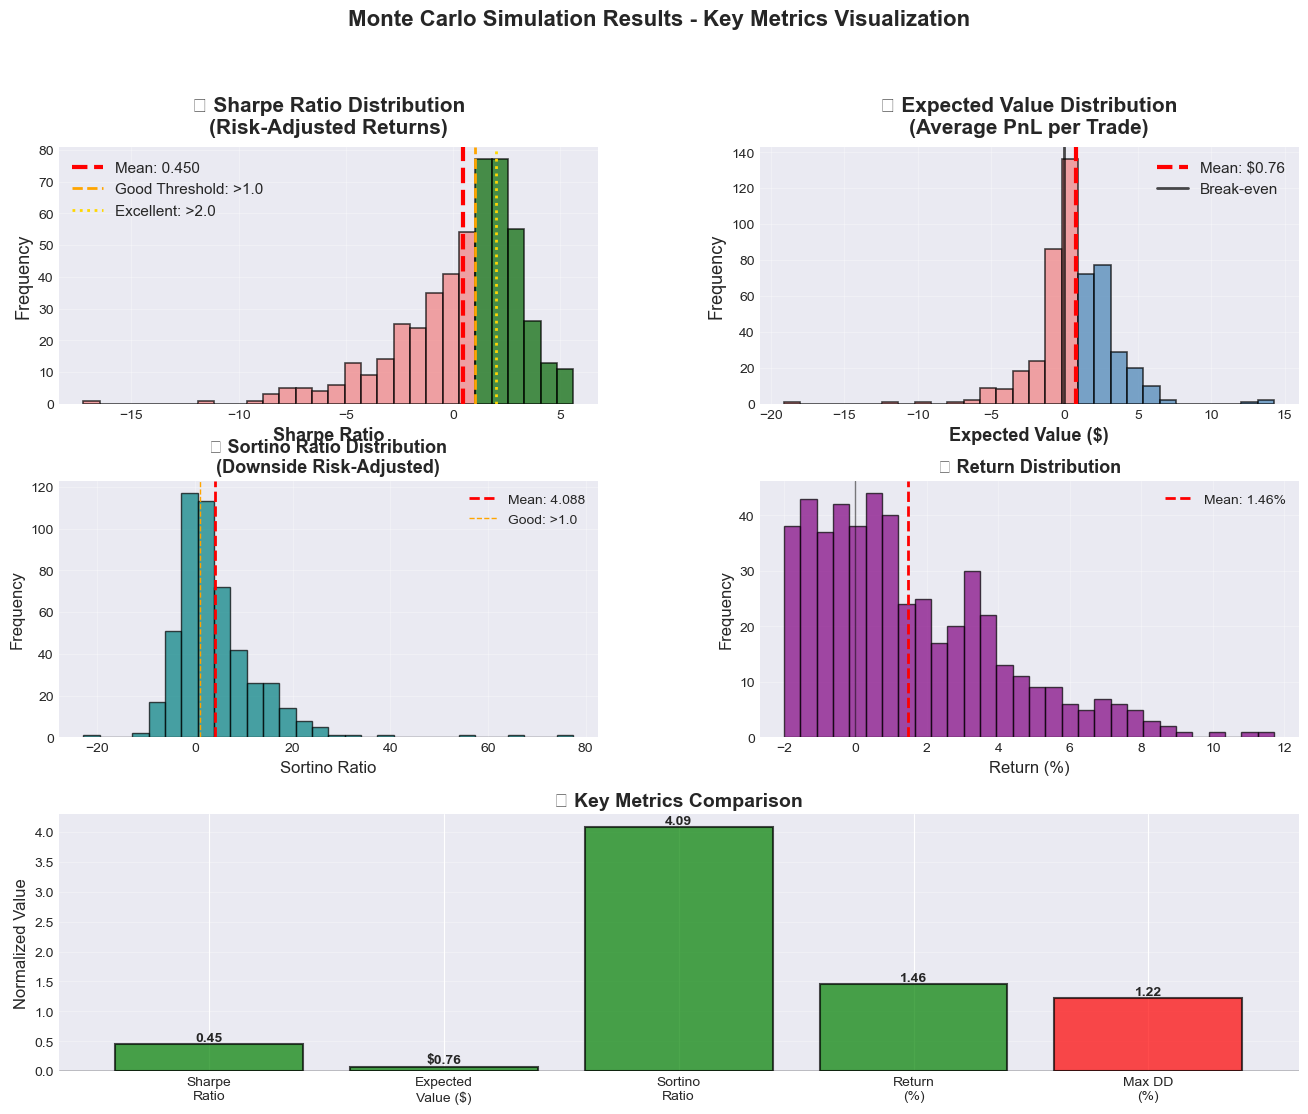

In [ ]:
# Create comprehensive visualizations
if len(results) > 0:
    # Create figure with 2x2 layout, emphasizing Sharpe and Expected Value
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Sharpe Ratio Distribution (Top Left - Prominent)
    ax1 = fig.add_subplot(gs[0, 0])
    n, bins, patches = ax1.hist(sharpe_ratios, bins=30, alpha=0.7, color='green', edgecolor='black', linewidth=1.2)
    ax1.axvline(avg_sharpe, color='red', linestyle='--', linewidth=3, label=f'Mean: {avg_sharpe:.3f}')
    ax1.axvline(1.0, color='orange', linestyle='--', linewidth=2, label='Good Threshold: >1.0')
    ax1.axvline(2.0, color='gold', linestyle=':', linewidth=2, label='Excellent: >2.0')
    ax1.set_xlabel('Sharpe Ratio', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=13)
    ax1.set_title('🎯 Sharpe Ratio Distribution\n(Risk-Adjusted Returns)', fontsize=15, fontweight='bold', pad=10)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    # Color bars based on value
    for i, (patch, bin_val) in enumerate(zip(patches, bins[:-1])):
        if bin_val >= 1.0:
            patch.set_facecolor('darkgreen')
        elif bin_val >= 0.5:
            patch.set_facecolor('lightgreen')
        else:
            patch.set_facecolor('lightcoral')
    
    # 2. Expected Value Distribution (Top Right - Prominent)
    ax2 = fig.add_subplot(gs[0, 1])
    n2, bins2, patches2 = ax2.hist(expected_values, bins=30, alpha=0.7, color='blue', edgecolor='black', linewidth=1.2)
    ax2.axvline(avg_expected_value, color='red', linestyle='--', linewidth=3, label=f'Mean: ${avg_expected_value:.2f}')
    ax2.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.7, label='Break-even')
    ax2.set_xlabel('Expected Value ($)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=13)
    ax2.set_title('💰 Expected Value Distribution\n(Average PnL per Trade)', fontsize=15, fontweight='bold', pad=10)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    # Color bars: green for positive, red for negative
    for i, (patch, bin_val) in enumerate(zip(patches2, bins2[:-1])):
        if bin_val >= 0:
            patch.set_facecolor('steelblue')
        else:
            patch.set_facecolor('lightcoral')
    
    # 3. Sortino Ratio Distribution (Middle Left)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.hist(sortino_ratios, bins=30, alpha=0.7, color='teal', edgecolor='black')
    ax3.axvline(avg_sortino, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_sortino:.3f}')
    ax3.axvline(1.0, color='orange', linestyle='--', linewidth=1, label='Good: >1.0')
    ax3.set_xlabel('Sortino Ratio', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('📈 Sortino Ratio Distribution\n(Downside Risk-Adjusted)', fontsize=13, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Return Distribution (Middle Right)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.hist(returns, bins=30, alpha=0.7, color='purple', edgecolor='black')
    ax4.axvline(np.mean(returns), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(returns):.2f}%')
    ax4.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax4.set_xlabel('Return (%)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('📉 Return Distribution', fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Key Metrics Comparison (Bottom - Span both columns)
    ax5 = fig.add_subplot(gs[2, :])
    metrics = ['Sharpe\nRatio', 'Expected\nValue ($)', 'Sortino\nRatio', 'Return\n(%)', 'Max DD\n(%)']
    values = [avg_sharpe, avg_expected_value/10, avg_sortino, np.mean(returns), np.mean(max_dds)]  # Scale EV for visibility
    colors = ['green' if v > 0 else 'red' for v in [avg_sharpe, avg_expected_value, avg_sortino, np.mean(returns), -np.mean(max_dds)]]
    bars = ax5.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax5.axhline(0, color='black', linestyle='-', linewidth=1)
    ax5.set_ylabel('Normalized Value', fontsize=12)
    ax5.set_title('📊 Key Metrics Comparison', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    # Add value labels on bars
    for i, (bar, val, orig_val) in enumerate(zip(bars, values, [avg_sharpe, avg_expected_value, avg_sortino, np.mean(returns), np.mean(max_dds)])):
        height = bar.get_height()
        label = f'{orig_val:.2f}' if i != 1 else f'${orig_val:.2f}'
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')
    
    plt.suptitle('Monte Carlo Simulation Results - Key Metrics Visualization', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.show()
    
else:
    print("No results to visualize. Run Monte Carlo simulation first.")


## 8. Summary & Interpretation

### 🎯 Key Metrics Explained:

#### **Sharpe Ratio** (Risk-Adjusted Returns)
- **Formula**: (Average Return - Risk-Free Rate) / Standard Deviation of Returns
- **Interpretation**: 
  - **> 2.0**: Excellent strategy
  - **1.0 - 2.0**: Good strategy
  - **0.5 - 1.0**: Moderate strategy
  - **< 0.5**: Poor strategy
- **What it tells you**: How much excess return you get per unit of risk

#### **Expected Value** (Average PnL per Trade)
- **Formula**: Average of all trade PnLs
- **Interpretation**:
  - **Positive**: Strategy is profitable on average
  - **Negative**: Strategy loses money on average
- **What it tells you**: Whether your strategy makes money over many trades

#### **Sortino Ratio** (Downside Risk-Adjusted Returns)
- **Similar to Sharpe but only considers downside volatility**
- **Better for strategies with asymmetric return distributions**
- **> 1.0**: Good downside protection

### 📊 Strategy Assessment Checklist:

Based on the Monte Carlo results, evaluate:

1. **✅ Profitability**: 
   - Expected Value > $0 = Profitable strategy
   - Higher Expected Value = More profitable per trade

2. **✅ Risk-Adjusted Performance**:
   - Sharpe Ratio > 1.0 = Good risk-adjusted returns
   - Higher Sharpe = Better risk-adjusted performance

3. **✅ Consistency**:
   - Low standard deviation in Sharpe/Expected Value = More consistent
   - High standard deviation = Unpredictable results

4. **✅ Risk Management**:
   - Lower Max DD = Better risk control
   - Pass Rate > 60% = Reliable strategy

5. **✅ Reliability**:
   - Higher Pass Rate = More likely to succeed in live trading
   - Consistent positive Expected Value = Sustainable strategy


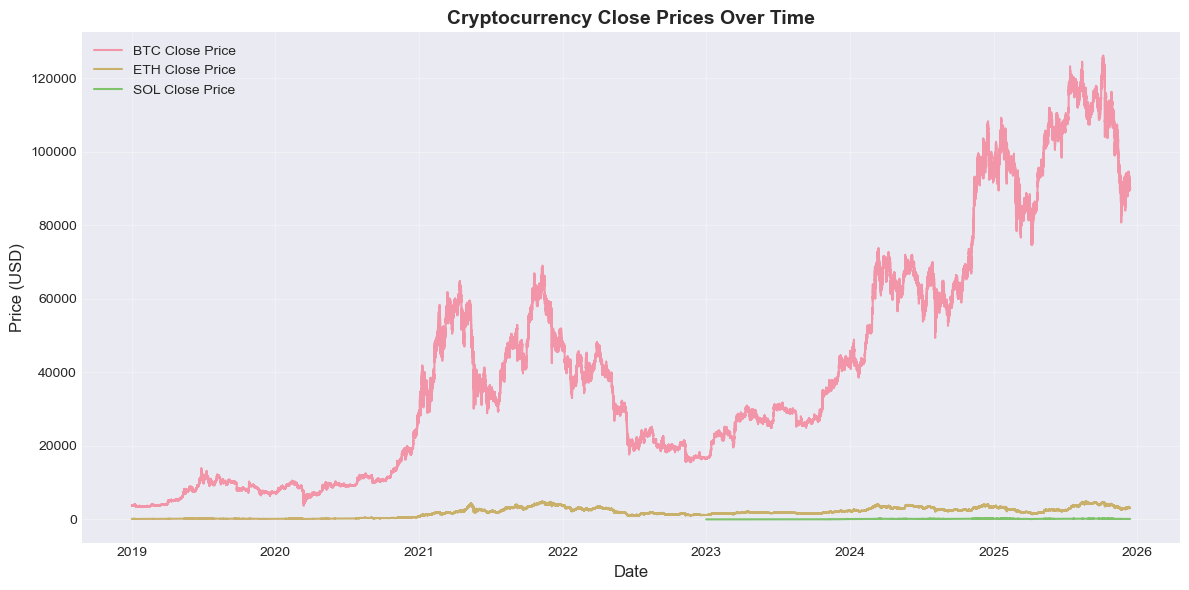

In [ ]:
# Plot Close prices with proper labels
plt.figure(figsize=(12, 6))

# Check if we have multiple tickers
if 'Ticker' in price.columns:
    tickers = price['Ticker'].unique()
    if len(tickers) > 1:
        # Plot each ticker separately with labels
        for ticker in tickers:
            ticker_data = price[price['Ticker'] == ticker]['Close']
            plt.plot(ticker_data.index, ticker_data.values, label=f'{ticker} Close Price', alpha=0.7)
        plt.legend()
        plt.title('Cryptocurrency Close Prices Over Time', fontsize=14, fontweight='bold')
    else:
        # Single ticker
        plt.plot(price['Close'], label=f'{tickers[0]} Close Price')
        plt.legend()
        plt.title(f'{tickers[0]} Close Price Over Time', fontsize=14, fontweight='bold')
else:
    # No ticker column, just plot all data
    plt.plot(price['Close'], label='Close Price')
    plt.legend()
    plt.title('Close Price Over Time', fontsize=14, fontweight='bold')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()